# Process ROMS output

- Import the 5-day averages
- Obtain annual averages
- 

In [236]:
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression as linr
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import regionmask
import copy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [237]:
data_type = 'ECCO'  # 'ORA', 'GLORYS', 'SODA', 'ECCO'
run = 'run1/complete_run'

path = f'/projects/0/einf2878/ROMS/data/{data_type}/roms_output/{run}'
data = xr.open_mfdataset(f'{path}/NorthSea4_av*.nc')

Be careful about incomplete years before taking annual averages!

In [276]:
data.zeta

<xarray.DataArray 'zeta' (ocean_time: 1534, eta_rho: 110, xi_rho: 122)>
dask.array<concatenate, shape=(1534, 110, 122), dtype=float32, chunksize=(874, 110, 122), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 122), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 122), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1992-01-18T12:00:00 ... 2013-01-1...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    standard_name:  sea_surface_elevation_anomaly
    long_name:      free-surface
    units:          meter
    time:           ocean_time
    cell_methods:   ocean_time: mean
    grid:           grid
    location:       face
    field:          free-surface

In [239]:
ssh = data.zeta

In [240]:
ssh

<xarray.DataArray 'zeta' (ocean_time: 1534, eta_rho: 110, xi_rho: 122)>
dask.array<concatenate, shape=(1534, 110, 122), dtype=float32, chunksize=(874, 110, 122), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 122), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 122), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1992-01-18T12:00:00 ... 2013-01-1...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    standard_name:  sea_surface_elevation_anomaly
    long_name:      free-surface
    units:          meter
    time:           ocean_time
    cell_methods:   ocean_time: mean
    grid:           grid
    location:       face
    field:          free-surface

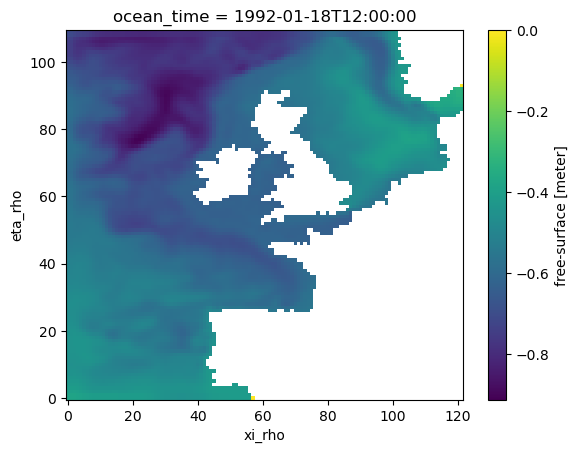

In [241]:
ssh.isel(ocean_time=0).plot()

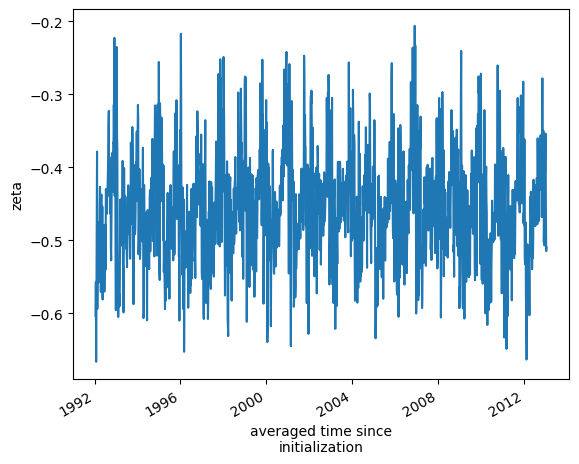

In [242]:
ssh.mean(['eta_rho', 'xi_rho']).plot()

In [243]:
# Obtain annual averages
ssh_annual = ssh.groupby(data.ocean_time.dt.year).mean('ocean_time', keep_attrs = True).rename({'year':'time'})

In [244]:
ssh_annual

<xarray.DataArray 'zeta' (time: 22, eta_rho: 110, xi_rho: 122)>
dask.array<stack, shape=(22, 110, 122), dtype=float32, chunksize=(1, 110, 122), chunktype=numpy.ndarray>
Coordinates:
    lon_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 122), meta=np.ndarray>
    lat_rho  (eta_rho, xi_rho) float64 dask.array<chunksize=(110, 122), meta=np.ndarray>
  * time     (time) int64 1992 1993 1994 1995 1996 ... 2009 2010 2011 2012 2013
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    standard_name:  sea_surface_elevation_anomaly
    long_name:      free-surface
    units:          meter
    time:           ocean_time
    cell_methods:   ocean_time: mean
    grid:           grid
    location:       face
    field:          free-surface

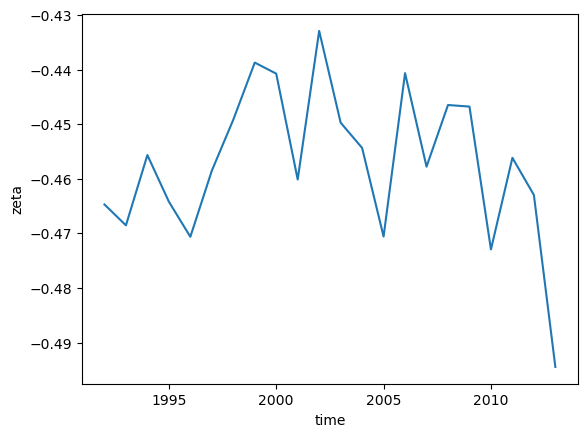

In [245]:
ssh_annual.mean(['eta_rho', 'xi_rho']).plot()

## Create new dataset for ROMS sea level

In [246]:
def roms_to_latlon(data):
    '''
    Function to obtain a new dataset for the roms data where dimensions are latitude and longitude 
    data should be the ROMS output dataset 
    '''
    
    data_vars = dict(zeta=(["time", "latitude", "longitude"], data.values),)
        
    coords = dict(time=(["time"], data.time.values),
             latitude=(["latitude"], data.lat_rho.values[:,0]),
             longitude=(["longitude"], data.lon_rho.values[0]))
    
    return xr.Dataset(data_vars = data_vars, coords = coords)

In [247]:
ssh_annual_latlon = roms_to_latlon(ssh_annual)

In [248]:
ssh_annual_latlon

<xarray.Dataset>
Dimensions:    (time: 22, latitude: 110, longitude: 122)
Coordinates:
  * time       (time) int64 1992 1993 1994 1995 1996 ... 2010 2011 2012 2013
  * latitude   (latitude) float64 35.95 36.25 36.56 36.86 ... 61.56 61.74 61.91
  * longitude  (longitude) float64 -19.88 -19.63 -19.39 ... 9.385 9.631 9.877
Data variables:
    zeta       (time, latitude, longitude) float32 -0.3224 -0.3224 ... nan nan

In [249]:
# Save annual sea-level data on NWES with dimension latitude & longitude
ssh_annual_latlon.to_netcdf(f'{path}/processed_data/ocdyn_NWES.nc')

## Select data near tide gauges


In [250]:
tg_coords = pd.read_csv('/projects/0/einf2878/ROMS/data/tide_gauges/tg_coords.csv', index_col = 'station')

In [251]:
tg_coords

,lat,lon
station,,
Vlissingen,51.442222,3.596111
Hoek van Holland,51.977500,4.120000
Den Helder,52.964444,4.745000
Delfzijl,53.326389,6.933056
Harlingen,53.175556,5.409444
IJmuiden,52.462222,4.554722


In [252]:
ocdyn_tide_gauges = pd.DataFrame({'time': ssh_annual_latlon.time}).set_index('time')

for station in tg_coords.index:
    
    ocdyn_tide_gauges[station] = ssh_annual_latlon.zeta.sel(latitude = tg_coords['lat'][station]+0.2,
                                                          longitude = tg_coords['lon'][station]-0.2,
                                                          method = 'Nearest')
    
ocdyn_tide_gauges['Average'] = ocdyn_tide_gauges.mean(axis=1)

In [253]:
ocdyn_tide_gauges

,Vlissingen,Hoek van Holland,Den Helder,Delfzijl,Harlingen,IJmuiden,Average
time,,,,,,,
1992,-0.400489,-0.391176,-0.389877,-0.364768,-0.380381,-0.380898,-0.384598
1993,-0.406805,-0.400743,-0.402148,-0.383128,-0.394723,-0.391831,-0.396563
1994,-0.380428,-0.369365,-0.371937,-0.343985,-0.361154,-0.355833,-0.363784
1995,-0.386332,-0.379281,-0.379393,-0.356528,-0.371598,-0.371295,-0.374071
1996,-0.451437,-0.453875,-0.460025,-0.464015,-0.460397,-0.454047,-0.457299
1997,-0.432040,-0.426316,-0.422607,-0.405076,-0.416013,-0.418672,-0.420121
1998,-0.352223,-0.338894,-0.341267,-0.307554,-0.328281,-0.323431,-0.331942
1999,-0.356848,-0.344935,-0.341143,-0.309469,-0.329408,-0.331172,-0.335496
2000,-0.358224,-0.344178,-0.343305,-0.312325,-0.331063,-0.327774,-0.336145


<AxesSubplot:xlabel='time'>

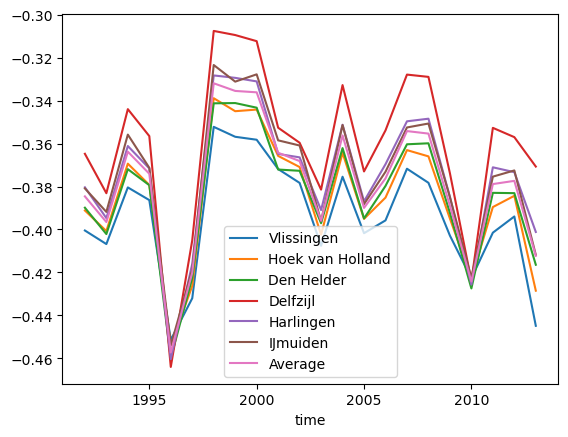

In [254]:
ocdyn_tide_gauges.plot()

In [255]:
# Save annual sea-level data near tide gauges 
ocdyn_tide_gauges.to_csv(f'{path}/processed_data/ocdyn_tidegauges.csv')

## Select data for polygon area to compare to altimetry data


In [256]:
def obtain_polygon_region_data(data, var):
    '''
    Function to obtain a new dataset containing the data averaged over polygon areas
    
    
    '''
    
    df = pd.DataFrame(index=pd.Series(data.time.values, name="time"))
    
    
    location = np.array([[2.5, 53], [3.3, 51.5], [4.25, 52.25], [4.75, 53.3], [5.5, 53.6], [7, 53.75], [7, 55], [4, 54.5]])
    
    region = regionmask.Regions([location], names=['reg'], abbrevs=['reg'])
    
    # Define the mask and change its value from 0 to 1
    mask_alti = region.mask_3D(data.longitude, data.latitude)
    
    data_m = data.where(mask_alti)
    
    
    # Calculate the weighted regional average
    # !!! Only works with regular grids
    weights = np.cos(np.deg2rad(data.latitude))
    region_average = data.weighted(mask_alti * weights).mean(dim=('latitude', 'longitude'))
    
    if len(var) == 1:
        var, = var
        df['Average'] = region_average[var] - region_average[var][0]
    else:
        for v in var:
            df[f'Average {v}'] = region_average[v] - region_average[v][0]
    
    return df 

In [257]:
# Select polygon data for sea level
ocdyn_polygon = obtain_polygon_region_data(ssh_annual_latlon, ['zeta'])

<AxesSubplot:xlabel='time'>

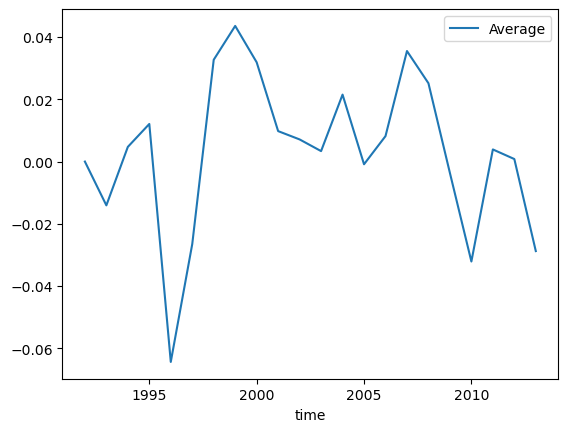

In [258]:
ocdyn_polygon.plot()

In [259]:
# Save annual sea-level data averaged over altimetry polygon area
ocdyn_polygon.to_csv(f'{path}/processed_data/ocdyn_polygon_altimetry.csv')

## Obtain wind contribution to ocean dynamic sea level using linear regression

In [260]:
# Import ERA5 wind stress data
wind_stress = xr.open_dataset('/projects/0/einf2878/ROMS/data/ERA/wind_stress/wind_stress.nc')

In [275]:
wind_stress

<xarray.DataArray 'u2' (time: 75, latitude: 121, longitude: 137)>
array([[[-1.227308, -1.05503 , ...,  0.160367,  0.092065],
        [-1.591457, -1.520357, ...,  0.358241,  0.316689],
        ...,
        [-0.053505, -0.067549, ..., -1.140957, -0.967327],
        [-0.21071 , -0.232015, ..., -1.40637 , -1.266663]],

       [[-0.596554, -0.47339 , ...,  0.138181,  0.047726],
        [-0.484257, -0.400134, ...,  0.331323,  0.263442],
        ...,
        [-3.152915, -3.132328, ..., -1.799458, -1.620506],
        [-3.284831, -3.272926, ..., -2.2751  , -2.106246]],

       ...,

       [[-0.801951, -0.630837, ...,  0.088708,  0.046924],
        [-1.043614, -0.926856, ...,  0.223959,  0.19796 ],
        ...,
        [-0.824995, -0.935769, ..., -0.720064, -0.551068],
        [-1.137533, -1.259907, ..., -1.145623, -0.936417]],

       [[-0.551611, -0.458332, ...,  0.235907,  0.186102],
        [-0.471844, -0.436102, ...,  0.42037 ,  0.378542],
        ...,
        [-1.565556, -1.609848, ..., -0.971342, -0.806084],
        [-1.85382 , -1.886899, ..., -1.526562, -1.312161]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -22.0 -21.75 -21.5 -21.25 ... 11.5 11.75 12.0
  * latitude   (latitude) float32 64.0 63.75 63.5 63.25 ... 34.5 34.25 34.0
  * time       (time) int64 1948 1949 1950 1951 1952 ... 2019 2020 2021 2022

In [262]:
# Obtain wind stress data averaged over tide gauges
ws_tide_gauges_u2 = pd.DataFrame({'time': wind_stress.time}).set_index('time')
ws_tide_gauges_v2 = pd.DataFrame({'time': wind_stress.time}).set_index('time')

for station in tg_coords.index:
    
    ws_tide_gauges_u2[station] = wind_stress.u2.sel(latitude = tg_coords['lat'][station],
                                                   longitude = tg_coords['lon'][station],
                                                   method = 'Nearest')
    ws_tide_gauges_v2[station] = wind_stress.v2.sel(latitude = tg_coords['lat'][station],
                                                   longitude = tg_coords['lon'][station],
                                                   method = 'Nearest')
    
ws_tide_gauges_u2['Average'] = ws_tide_gauges_u2.mean(axis=1)
ws_tide_gauges_v2['Average'] = ws_tide_gauges_v2.mean(axis=1)

wind_stress_tide_gauges = pd.DataFrame({'time': wind_stress.time, 'Average u2': ws_tide_gauges_u2['Average'], 
                               'Average v2': ws_tide_gauges_v2['Average']}).set_index('time')

In [263]:
wind_stress_tide_gauges

,Average u2,Average v2
time,,
1948,3.449767,2.600676
1949,3.979109,0.729791
1950,4.435678,3.140815
1951,2.304524,2.689281
1952,2.998334,0.218524
...,...,...
2018,0.510473,0.537727
2019,3.726621,2.429710
2020,4.554488,3.656971


In [264]:
# Select polygon data for wind stress
wind_stress_polygon = obtain_polygon_region_data(wind_stress, ['u2', 'v2'])

In [265]:
wind_stress_polygon

,Average u2,Average v2
time,,
1948,0.000000,0.000000
1949,1.994145,-2.372706
1950,1.153212,0.460878
1951,-1.624835,0.612214
1952,-0.797835,-3.933789
...,...,...
2018,-4.227577,-2.445565
2019,0.942225,-0.444895
2020,2.163527,1.423287


In [266]:
def regression(sea_data, wind_data, name):
    """
    Function to perform the regression with sea-level and wind-stress data to obtain the wind effect on 
    sea level along the Dutch coast.
    
    """
    
    
    
    # Obtain trend timeseries to add to dataframe later
    trend = wind_data.index - wind_data.index[0]
    
    
    # Create lists containing names of regression terms
    regg_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$', 'trend']
    wind_names = ['$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    
    
    # Create dataframe for y 
    y = sea_data
    
    # Create dataframe for x
    x = pd.DataFrame(data={'time': wind_data.index,
                            '$U \sqrt{u^2+v^2}$': wind_data['Average u2'],
                            '$V \sqrt{u^2+v^2}$': wind_data['Average v2'],
                            'trend': trend,})
        
    x = x.set_index('time')
        
    # Define regression
    regression_ = linr()
        
        
    # Interpolate to remove nan values
    x = x.interpolate(axis=0)
    y = y.interpolate(axis=0)
        
        
    # Standardize x
    scaler = StandardScaler()
    x = copy.deepcopy(x)
    x.iloc[:,:] = scaler.fit_transform(x)
        
        
    # Create copy such that regression result can be obtained for full timeseries
    x_timeseries = copy.deepcopy(x)
        
        
    # Create dataframes of equal time span
    y = y[y.index.isin(x.index)]
    x = x[x.index.isin(y.index)]
        
        
    # Fit the regression model and add results to lists
    fit = regression_.fit(x,y)
    score = regression_.score(x,y) # R^2 for the whole regression including the trend 
    intercept = regression_.intercept_
    coefs = regression_.coef_.T
    
    
    # Calculate rmse
    yhat = regression_.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse
    rmse = np.sqrt(mse)
        
        
    # Obtain dataframe containing timeseries resulting from regression
    df = pd.DataFrame(data=dict(time=x_timeseries.index))
    df = df.set_index('time')
    
    
    for i, reg in enumerate(regg_names):
        df[reg] = coefs[i] * x_timeseries[reg]
            
    df['total'] = df.sum(axis=1)
    df['wind total'] = df[wind_names].sum(axis=1)

        
    # Calculate R^2 values
    R2_total = score # R^2 for the whole regression including the trend
    R2_wind = R2_var(df, y, 'wind total', regression_)
    R2_u2 = R2_var(df, y, '$U \sqrt{u^2+v^2}$', regression_)
    R2_v2 = R2_var(df, y, '$V \sqrt{u^2+v^2}$', regression_)
                

    
    
    # Save dataframe
    #df.to_csv(f'{path}/timeseries_{name}_poly.csv')
    
    
    
    # Create dataframe of coefficients
    
    
    results_df = pd.DataFrame(data={'Coefficient': ['R$^2$', 'R$^2_{wind}$', 'R$^2_{U \sqrt{u^2+v^2}}$', 'R$^2_{V \sqrt{u^2+v^2}}$', 'RMSE', 'constant', 'coef$_{U \sqrt{u^2+v^2}}$', 'coef$_{V \sqrt{u^2+v^2}}$', 'coef$_{trend}$']}).set_index('Coefficient')
    
    results_df['Result'] = [R2_total, R2_wind, R2_u2, R2_v2, rmse, intercept[0], coefs[0][0], coefs[1][0], coefs[2][0]]
    
    
    
    # Save dataframe
    #results_df.to_csv(f'{path}/results_{name}_poly.csv')
    
    
    return(results_df, df)


    
    
def R2_var(df, y, var, regression_):
    """
    Function to obtain R-squared for a specific variable
    
    For var choose  ['wind total', '$U \sqrt{u^2+v^2}$', '$V \sqrt{u^2+v^2}$']
    """
    
    x = pd.DataFrame(data={'time': df.index.values, 
                                var : df[var].values})
    x = x.set_index('time')
    x = x[x.index.isin(y.index)]
    
    fit = regression_.fit(x, y)
    score = regression_.score(x,y)
    
    return score


In [267]:
ocdyn_tide_gauges_av = ocdyn_tide_gauges.drop(tg_coords.index, axis=1)

In [268]:
results_polygon, timeseries_polygon = regression(ocdyn_polygon, wind_stress_polygon, 'roms')
results_tide_gauges, timeseries_tide_gauges = regression(ocdyn_tide_gauges_av, wind_stress_tide_gauges, 'roms')

In [269]:
results_polygon

,Result
Coefficient,
R$^2$,0.683824
R$^2_{wind}$,0.683815
R$^2_{U \sqrt{u^2+v^2}}$,0.665086
R$^2_{V \sqrt{u^2+v^2}}$,0.218694
RMSE,0.013898
constant,0.003152
coef$_{U \sqrt{u^2+v^2}}$,0.024955
coef$_{V \sqrt{u^2+v^2}}$,-0.004935
coef$_{trend}$,0.000249


In [270]:
timeseries_polygon

,$U \sqrt{u^2+v^2}$,$V \sqrt{u^2+v^2}$,trend,total,wind total
time,,,,,
1948,0.007815,-0.007024,-0.000425,0.000365,0.000790
1949,0.025163,0.000300,-0.000414,0.025049,0.025463
1950,0.017847,-0.008447,-0.000402,0.008998,0.009400
1951,-0.006321,-0.008914,-0.000391,-0.015625,-0.015235
1952,0.000874,0.005119,-0.000379,0.005613,0.005993
...,...,...,...,...,...
2018,-0.028963,0.000525,0.000379,-0.028059,-0.028438
2019,0.016012,-0.005651,0.000391,0.010751,0.010361
2020,0.026636,-0.011418,0.000402,0.015621,0.015219


In [271]:
results_tide_gauges

,Result
Coefficient,
R$^2$,0.751972
R$^2_{wind}$,0.751722
R$^2_{U \sqrt{u^2+v^2}}$,0.751076
R$^2_{V \sqrt{u^2+v^2}}$,0.449407
RMSE,0.015038
constant,-0.381279
coef$_{U \sqrt{u^2+v^2}}$,0.027415
coef$_{V \sqrt{u^2+v^2}}$,-0.001296
coef$_{trend}$,0.001633


In [272]:
timeseries_tide_gauges

,$U \sqrt{u^2+v^2}$,$V \sqrt{u^2+v^2}$,trend,total,wind total
time,,,,,
1948,0.007321,-0.001668,-0.002791,0.002863,0.005654
1949,0.015366,0.000582,-0.002715,0.013233,0.015948
1950,0.022305,-0.002317,-0.002640,0.017348,0.019988
1951,-0.010083,-0.001774,-0.002564,-0.014422,-0.011858
1952,0.000461,0.001197,-0.002489,-0.000831,0.001657
...,...,...,...,...,...
2018,-0.037349,0.000813,0.002489,-0.034047,-0.036536
2019,0.011529,-0.001462,0.002564,0.012631,0.010067
2020,0.024110,-0.002938,0.002640,0.023813,0.021173


### Create new dataframes

Containing ocean-dynamic sea level, wind contribution and local steric along the Dutch coast
- averaged over tide gauge locations to compare to tide gauges
- averaged over polygon area to compare to altimetry

In [273]:
ocdyn = ocdyn_tide_gauges['Average']
wind = timeseries_tide_gauges.loc[ocdyn_tide_gauges.index[0]:ocdyn_tide_gauges.index[-1]]['wind total']
locster = ocdyn - wind

ssh_tide_gauges = pd.DataFrame({'time': ocdyn_tide_gauges.index,
                               'ocdyn': ocdyn,
                               'wind': wind,
                               'locster': locster},
                               ).set_index('time')

# Save annual sea-level data near tide gauges 
ssh_tide_gauges.to_csv(f'{path}/processed_data/ssh_tidegauges.csv')

In [274]:
ocdyn = ocdyn_polygon['Average']
wind = timeseries_polygon.loc[ocdyn_polygon.index[0]:ocdyn_polygon.index[-1]]['wind total']
locster = ocdyn - wind

ssh_polygon = pd.DataFrame({'time': ocdyn_tide_gauges.index,
                               'ocdyn': ocdyn,
                               'wind': wind,
                               'locster': locster},
                               ).set_index('time')

# Save annual sea-level data near tide gauges 
ssh_polygon.to_csv(f'{path}/processed_data/ssh_polygon_altimetry.csv')